# Medical Image Segmentation. Traditional vs Deep Learning methods.

In this Practice, you will develop and train a convolutional neural network for brain tumour image segmentation
and compare the performance with respect to traditional methods for image segmentation. 

When you train the network, it is recommended to use the GPU resources of your computer. 
This will help you to learn the "know how" of setting up a working Python environment on your computer.

In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.


In [1]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.
import tarfile
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchsummary import summary

import numpy as np
import time
import os
import random

import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import random

## Download the imaging dataset

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this practice, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-04-08 10:09:38--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-04-08 10:09:40--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4d4aa01fec120c3b95244b1e83.dl.dropboxusercontent.com/cd/0/inline/B5xgRX6m9QZN4HhgnxYLnMZkpp-4EeAsQPIh6I8iTYWtKakdEUdBfPQlEHi1HdNYfT3TRLLFmvHbPegASjdECjFzBEjrGq6CiISbd-krtl7Kl3woLCUyjijVXk1Ehl7T1PauYSjZdYJfZMO5LkiR5OrVwgfMPI6dT66MS-E8uYxnVw/file# [following]
--2023-04-08 10:09:40--  https://uc4d4aa01fec120c3b95244b1e83.dl.dropboxusercontent.com/cd/0/inline/B5xgRX6m9QZN4HhgnxYLnMZkpp-4E

## Visualize the imaging dataset

Select a number of training and test images and visualize them in a grid to have an initial idea of the data.

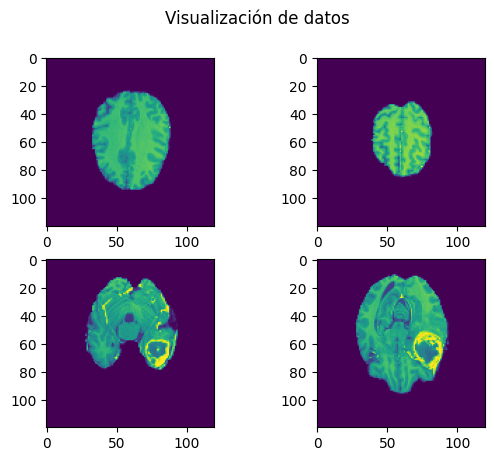

In [3]:
### Insert your code ###
fig, axs = plt.subplots(2, 2)
fig.suptitle('Visualización de datos')
img = np.asarray(Image.open('Task01_BrainTumour_2D/training_images/BRATS_001_z108.png'))
axs[0,0].imshow(img)
img = np.asarray(Image.open('Task01_BrainTumour_2D/training_images/BRATS_001_z124.png'))
axs[0,1].imshow(img)
img = np.asarray(Image.open('Task01_BrainTumour_2D/training_images/BRATS_001_z46.png'))
axs[1,0].imshow(img)
img = np.asarray(Image.open('Task01_BrainTumour_2D/training_images/BRATS_001_z62.png'))
axs[1,1].imshow(img)
### End of your code ###

# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        
        # Initialize self variables
        ### Insert your code ###
        
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []
        ### End of your code ###
        
        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image. Use imageio.imread.
            ### Insert your code ###
            
            #Cuidado! La barra depende del SO donde se ejecute. En linux es / no \
            image = imageio.imread(image_path+"/"+image_name)  ###code
            
            self.images += [image]

            # Read the label map
            if not self.deploy:
                ### Insert your code ###
                label = imageio.imread(label_path+"/"+image_name)
                self.labels += [label]
                ### End of your code ###
        

    def __len__(self): # Number of images
        ### Insert your code ###
        return len(self.images)
        ### End ofreturn len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        ### Insert your code ###
        
        image = self.images[idx]
        image = normalise_intensity(image)
        ### End of your code ###
        
        # Get its label map
        # Dimension: XY
        ### Insert your code ###
        label = self.labels[idx]
        ### End of your code ###
        
        return image, label

    
    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        for i in range(batch_size):
            idx = random.randint(0,len(self.images)-1)
            images += [self.images[idx]]
            labels += [self.labels[idx]]
        ### End of your code ###
        
        images = np.array( images )
        print(images.shape)
        
        images = np.expand_dims(images, axis = 1) #NCXY dimension, with C = 1

        labels = np.array( labels )

        return images, labels
    

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [5]:
        
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
         #   nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            )
        
        n *= 2  # 64
        self.conv3 = nn.Sequential(
         #   nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            )
            
        n *= 2  # 128
        self.conv4 = nn.Sequential(
          #  nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            )
        
        n *= 2  # 256
        self.conv5 = nn.Sequential(
          #  nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            )

        n = int(n / 2)  # 128
        self.up4 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up4 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 64
        self.up3 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up3 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.up2 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up2 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
            
        n = int(n / 2)  # 16
        self.up1 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up1 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        
        # Output
        self.out = nn.Conv2d(n, output_channel, kernel_size=1, padding=0)

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)
        conv4_skip = x

        # Decoder

        x = self.up4(x)
        x = torch.cat([conv4_skip, x], dim=1)
        x = self.conv_up4(x)
            
        x = self.up3(x)
        x = torch.cat([conv3_skip, x], dim = 1)
        x = self.conv_up3(x)
        
        x = self.up2(x)
        x = torch.cat([conv2_skip, x], dim = 1)
        x = self.conv_up2(x)

        x = self.up1(x)
        x = torch.cat([conv1_skip, x], dim = 1)
        x = self.conv_up1(x)
        
        return x

# Train the segmentation model

In [6]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
"""
- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour
"""
num_class = 4

model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

summary(model,(1,128,128))

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Adam Optimizer
### Insert your code ###
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
### End of your code ###

# Segmentation loss. Criterion: Cross Entropy Loss.
### Insert your code ###
criterion = nn.CrossEntropyLoss()
### End of your code ###

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16

start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a random batch of images and labels
    ### Insert your code ###
    images, labels = train_set.get_random_batch(train_batch_size)
    ### End of your code ###
    
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)
    
    # Note that optimizer.zero_grad() is equivalent to net.zero_grad() if it optimises all the net parameters.
    optimizer.zero_grad()

    # Perform optimisation: compute the loss, backpropagation, and perform a step of your optimizer
    ### Insert your code ###
    loss = criterion(logits, labels)
    loss.backward()
    ### End of your code ###

    print('--- Iteration {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(it, loss.item(), time.time() - start_iter))

    # Evaluate
    if it % 10 == 0:
        model.eval()
        # Disabling gradient calculation during inference to reduce memory consumption
        with torch.no_grad():
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = criterion(logits, labels)
            print('--- Iteration {0}: Test loss = {1:.4f} ---\n'.format(it, loss.item()))

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
        
print('Training took {:.3f}s in total.'.format(time.time() - start))

Se han truncado las últimas 5000 líneas del flujo de salida.
--- Iteration 7828: Training loss = 2.9650, 0.0366 s ---
(16, 120, 120)
--- Iteration 7829: Training loss = 2.9626, 0.0432 s ---
(16, 120, 120)
--- Iteration 7830: Training loss = 2.9677, 0.0373 s ---
(16, 120, 120)
--- Iteration 7830: Test loss = 2.9558 ---

(16, 120, 120)
--- Iteration 7831: Training loss = 2.9696, 0.0364 s ---
(16, 120, 120)
--- Iteration 7832: Training loss = 2.9672, 0.0391 s ---
(16, 120, 120)
--- Iteration 7833: Training loss = 2.9632, 0.0359 s ---
(16, 120, 120)
--- Iteration 7834: Training loss = 2.9632, 0.0361 s ---
(16, 120, 120)
--- Iteration 7835: Training loss = 2.9661, 0.0353 s ---
(16, 120, 120)
--- Iteration 7836: Training loss = 2.9686, 0.0362 s ---
(16, 120, 120)
--- Iteration 7837: Training loss = 2.9707, 0.0374 s ---
(16, 120, 120)
--- Iteration 7838: Training loss = 2.9651, 0.0377 s ---
(16, 120, 120)
--- Iteration 7839: Training loss = 2.9644, 0.0377 s ---
(16, 120, 120)
--- Iteration 78

# Visualise the segmentation results

In [37]:
# Get a random batch of test images
# Segment the images using the trained model
images, labels = test_set.get_random_batch(5)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
model.eval()
logits = model(images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=1)

(5, 120, 120)


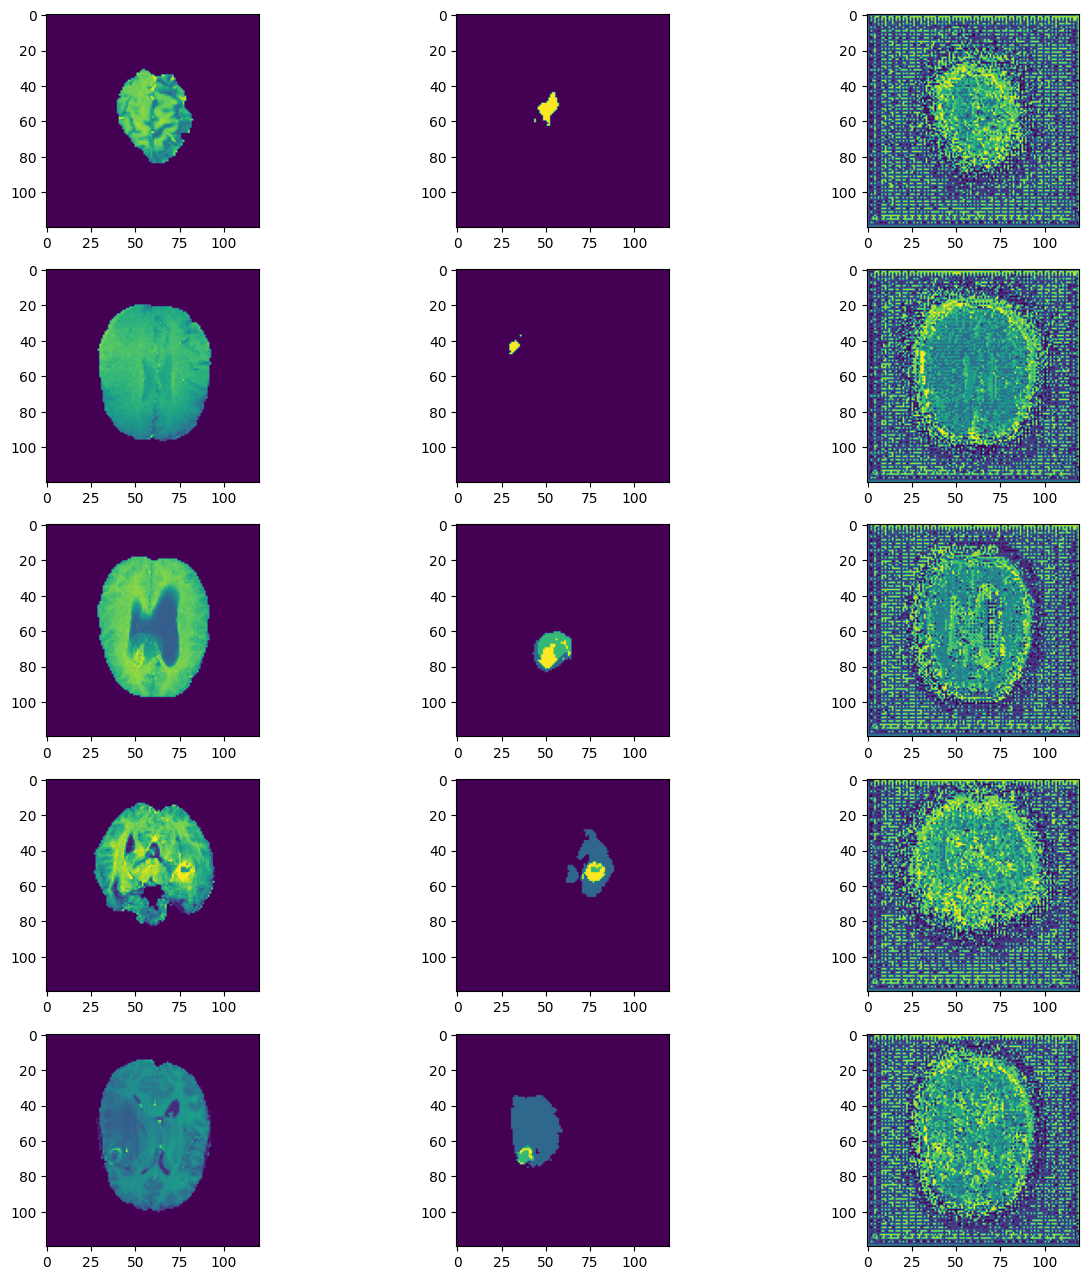

In [49]:
# Visualise the image, automated segmentation and manual segmentation
fig, axs = plt.subplots(5, 3, figsize=(15, 16))


### Insert your code ###
images_tensor = images.cpu()
labels_tensor = labels.cpu().numpy()
seg_tensor = seg.cpu().numpy()
for i in range(5):
    axs[i,0].imshow(images_tensor[i].permute(1, 2, 0))
    axs[i,1].imshow(labels_tensor[i])
    axs[i,2].imshow(seg_tensor[i])
### End of your code ###


## Evaluate the segmentation results

Use the Dice Similarity Coefficient (DSC) for the edema, non-enhancing tumour, enhancing tumour
Show boxplots of the similarity distribution on your test set


In [ ]:
### Insert your code ###

# Get a random batch of test images
# Segment the images using the trained model
images, labels = test_set.get_random_batch(200)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
model.eval()
logits = model(images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=1)

### End of your code ###

In [ ]:
## Investigating traditional methods

Select three images with low, medium, and high DSC score and try to segment the labels with traditional methods
of your choice. Explain your conclusions in this notebook.

In [ ]:
### Insert your code ###
[Insert your code here]
### End of your code ###